# Calculating $\Delta v$

## Theory

### Tsiolkovsky rocket equation

$
\large \Delta v=v_e*\ln\frac{m_0}{m_f}
$

$\Delta v$ - the maximum change of velocity of the vehicle

$m_0$ - the initial total mass, including propellant, a.k.a. "wet mass"

$m_f$ - the final total mass without propellant, a.k.a. "dry mass"

$v_{\text{e}}$ - the effective exhaust velocity

$\ln$ - the natural logarithm function

### Calculating $\Delta v$ given $I_{sp}$, wet mass ($m_0$) and dry mass ($m_f$)

**Using the specific impulse instead of the effective exhaust velocity**

$
\large v_e=I_{sp}*g_0
$

$
\large {\Delta}v=I_{sp}*g_0*ln\frac{m_0}{m_f}
$

$I_{sp}$ - is the specific impulse in $s$

$g_{0}$ - is the surface gravity (exactly $9.80665 \frac{m}{s^2}$)

In [1]:
import numpy as np

In [2]:
G_0 = 9.80665

def delta_v(isp, wet_mass, dry_mass):
    return isp * G_0 * np.log(wet_mass / dry_mass)

### Calculating fuel mass given dry mass ($m_f$), $\Delta v$ and $I_{sp}$ 

$
\large {m_0} = m_f * \exp(\frac{\Delta v}{I_{sp} * g_0})
$

$
\large fuel\_mass = m_0 - m_f
$


In [3]:
def fuel_mass(dry_mass, dv, isp):
    wet_mass = dry_mass * np.exp(dv / (G_0 * isp))
    return wet_mass - dry_mass

### Calculating $I_{sp}$ for multiple engines

Weighted harmonic mean of the engines' specific impulses, weighted by each engine's thrust. 

$
\large 
I_{sp}=\frac{\sum_{i=1}^{n}F_{T_{i}}}{\sum_{i=1}^{n}\dot {m}_{i}}=\frac{\sum_{i=1}^{n}F_{T_{i}}}{\sum_{i=1}^{n}{\frac{F_{T_{i}}}{I_{s{p_{i}}}}}}
$


$F_{T_i}$ - the thrust of each engine in $N$ (newton)

$I_{s{p_i}}$ - the specific impulse of each engine in $s$

$\dot {m}_i$ - the fuel consumption in $\frac{kg}{s}$


In [4]:
def isp_engines(thrusts, isps):
    return np.sum(thrusts) / np.sum(np.divide(thrusts, isps))

### Fuel consumption & volume


$
\large \dot m = \frac {\sum_{i=1}^{n} F_{T_{i}}}{I_{sp} * g_0}
$

$
\dot V = \frac {\dot m}{\rho}
$

$\dot V$ - the fuel volume in $\frac {m^3}{s}$

$\rho$ - the fuel density in $\frac {kg}{m^3}$ 

In [5]:
def fuel_consumption(thrust, isp):
    """Calculate fuel consumption in kg/s given total thrust and Isp or all engines"""
    return thrust / (isp * G_0)

def mass_to_volume(m_dot, density):
    """Converts mass in kg/s to volume in l/s"""
    return (m_dot / density) * 1000

def volume_to_mass(vol, density):
    """Converts volume in l/s to mass in kg/s"""
    return (vol / 1000) * density

---

## Example 1: Amount of fuel necessary to reach LEO

In [6]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [7]:
# delta_v necessary to reach LEO + approximate atmospheric & gravity drag
target_delta_v = 9400

# various Isp values
isps = np.arange(200, 400, 50)

# various dry mass
dry_mass = np.arange(0, 10, 1)

# calculate fuel mass for above parameters
fm = [fuel_mass(dry_mass, target_delta_v, isp) for isp in isps]

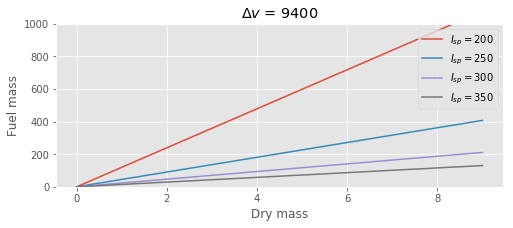

In [8]:
fig, ax = plt.subplots(1, figsize=(8,3))

for i, isp in enumerate(isps):
    ax.plot(dry_mass, fm[i], label='$I_{{sp}}={}$'.format(isp))

ax.set_ylim(0, 1000)
ax.set_title('$\Delta v$ = {}'.format(target_delta_v))
ax.set_xlabel('Dry mass');
ax.set_ylabel('Fuel mass');
ax.legend(loc='upper right');

## Example 2: Launching Falcon 9 v1.2 (Full Thrust) into orbit

<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/Falcon_9_logo_by_SpaceX.png" width="100">

| Stage | Engines           | $I_{sp}$ | Thrust | Dry mass  | Fuel       | Fuel volume | Burn time |
| ----- | ----------------- | -------- | ------ | --------- | ---------- | ----------- | --------- |
| 1     | 9 x Merlin 1D+    | 282 s    | 845 kN | 25,600 kg | LOx + RP-1 | 398,887 L   | 162 s     |
| 2     | 1 x Merlin 1D+Vac | 348 s    | 934 kN | 4,000 kg  | LOx + RP-1 | 108,185 L   | 346 s     |


Mixture mass ratio = $2.36$

LOx density: $1.141 \frac{g}{cm^3}$

RP-1 density: $0.81 \sim 1.02 \frac{g}{cm^3}$

In [9]:
mixture_mass_ratio = 2.36
# weighted average fuel density, assuming density of RP-1 is at the higher end (1.02g/cm^3)
density = ((mixture_mass_ratio * 1141) + (1 * 1020)) / (mixture_mass_ratio + 1)

isp_1st_stage = 282
thrust_1st_stage = 845000
burn_time_1st_stage = 162
dry_mass_base_1st_stage = 25600
fuel_volume_1st_stage = 398887
fuel_mass_1st_stage = volume_to_mass(fuel_volume_1st_stage, density)

isp_2nd_stage = 346
thrust_2nd_stage = 934000
burn_time_2nd_stage = 397
dry_mass_base_2nd_stage = 4000
fuel_volume_2nd_stage = 108185
fuel_mass_2nd_stage = volume_to_mass(fuel_volume_2nd_stage, density)

In [10]:
# parameters for all 1st stage engines are the same so calculating total Isp is trivial,
# but technically speaking it should be calculated in the following way:
thrusts = [845000, 845000, 845000, 845000, 845000, 845000, 845000, 845000, 845000]
isps = [282, 282, 282, 282, 282, 282, 282, 282, 282]
isp_1st_stage = isp_engines(thrusts, isps)
isp_1st_stage

282.0

#### Fuel consumption

In [11]:
# fuel consumption for 9 Merlin 1D+ engines in kg/s
m_dot_1st_stage = fuel_consumption(9 * thrust_1st_stage, isp_1st_stage)

# fuel volume in l/s
V_dot_1st_stage = mass_to_volume(m_dot_1st_stage, density)
V_dot_1st_stage

2488.695917581072

In [12]:
# total fuel consumption for given burn time and volume consumption per second
calculated_fuel_volume_1st_stage = burn_time_1st_stage * V_dot_1st_stage
calculated_fuel_volume_1st_stage

403168.7386481337

In [13]:
# fuel consumption for 1 Merlin 1D+Vecuum engine in kg/s
m_dot_2nd_stage = fuel_consumption(thrust_2nd_stage, isp_2nd_stage)

# fuel volume in l/s
V_dot_2nd_stage = mass_to_volume(m_dot_2nd_stage, density)
V_dot_2nd_stage

249.11076920790754

In [14]:
# total fuel consumption for given burn time and volume consumption per second
calculated_fuel_volume_2nd_stage = burn_time_2nd_stage * V_dot_2nd_stage
calculated_fuel_volume_2nd_stage

98896.97537553929

#### Burn time

In [15]:
# maximum burn time on full thrust
calculated_burn_time_1st_stage = fuel_volume_1st_stage / V_dot_1st_stage
calculated_burn_time_1st_stage

160.2795251851036

In [16]:
# maximum burn time on full thrust
calculated_burn_time_2nd_stage = fuel_volume_2nd_stage / V_dot_2nd_stage
calculated_burn_time_2nd_stage

434.2847173728926

#### Minimum fuel mass to reach orbit, without payload

In [17]:
min_fuel_mass_leo_1st_stage = fuel_mass(dry_mass_base_1st_stage, 9400, isp_1st_stage)
min_fuel_mass_leo_1st_stage

740755.6789047227

In [18]:
min_fuel_mass_leo_2nd_stage = fuel_mass(dry_mass_base_2nd_stage, 9400, isp_2nd_stage)
min_fuel_mass_leo_2nd_stage

59855.43146870513

#### Maximum $\Delta v$, without payload

In [19]:
delta_v_1st_stage = delta_v(isp_1st_stage, dry_mass_base_1st_stage + fuel_mass_1st_stage, dry_mass_base_1st_stage)
delta_v_1st_stage

8026.452088059146

In [20]:
delta_v_2nd_stage = delta_v(isp_2nd_stage, dry_mass_base_2nd_stage + fuel_mass_2nd_stage, dry_mass_base_2nd_stage)
delta_v_2nd_stage

11639.340519804397

#### $\Delta v$ for different payload mass

In [36]:
minimum_two_stages_mass = dry_mass_base_1st_stage + dry_mass_base_2nd_stage + fuel_mass_2nd_stage
maximum_payload_mass = 50000
max_x = minimum_two_stages_mass + 25000
max_x = maximum_payload_mass
# maximum delta v for 1st stage
dry_mass_1st_stage = np.arange(dry_mass_base_1st_stage, dry_mass_base_1st_stage + max_x, 1000)
wet_mass_1st_stage = dry_mass_1st_stage + fuel_mass_1st_stage
dv_1st_stage = delta_v(isp_1st_stage, wet_mass_1st_stage, dry_mass_1st_stage)

# maximum delta v for 1st stage with 2nd stage on top
dv_1st_stage_with_2nd_stage = delta_v(isp_1st_stage, minimum_two_stages_mass + fuel_mass_1st_stage, minimum_two_stages_mass)

# maximum delta v for 2nd stage (after separation)
dry_mass_2nd_stage = np.arange(dry_mass_base_2nd_stage, dry_mass_base_2nd_stage + max_x, 1000)
wet_mass_2nd_stage = dry_mass_2nd_stage + fuel_mass_2nd_stage
dv_2nd_stage = delta_v(isp_2nd_stage, wet_mass_2nd_stage, dry_mass_2nd_stage)

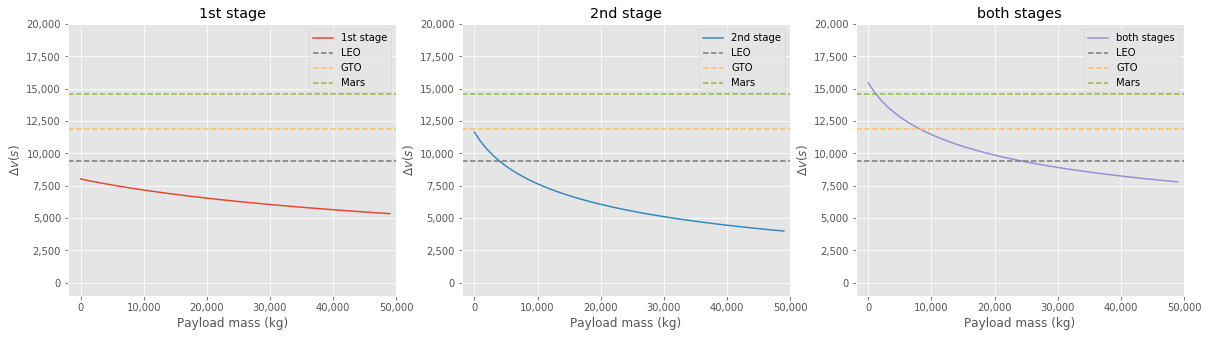

In [44]:
delta_v_LEO = 9400 # Low Earth Orbit
delta_v_GTO = 11900 # Geostationary Transfer Orbit
delta_v_Mars = 14600 # Mars capture orbit

def draw_plot(ax, x, y, color, label):
    formatter = matplotlib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x)))
    ax.plot(x, y, color, label=label)
    ax.set_title(label)
    ax.get_xaxis().set_major_formatter(formatter)
    ax.get_yaxis().set_major_formatter(formatter)
    ax.set_xlabel('Payload mass (kg)');
    ax.set_ylabel('$\Delta v (s)$');
    ax.set_xlim(-2000, max_x)
    ax.set_ylim(-1000, 20000)
    ax.axhline(delta_v_LEO, linestyle='--', color='C3', label='LEO')
    ax.axhline(delta_v_GTO, linestyle='--', color='C4', label='GTO')
    ax.axhline(delta_v_Mars, linestyle='--', color='C5', label='Mars')

    ax.legend(loc='upper right');

fig, ax = plt.subplots(1, 3, figsize=(20,5))

draw_plot(ax[0], dry_mass_1st_stage - dry_mass_base_1st_stage, dv_1st_stage, 'C0', '1st stage')
draw_plot(ax[1], dry_mass_2nd_stage - dry_mass_base_2nd_stage, dv_2nd_stage, 'C1', '2nd stage')
draw_plot(ax[2], dry_mass_2nd_stage - dry_mass_base_2nd_stage, dv_1st_stage_with_2nd_stage + dv_2nd_stage, 'C2', 'both stages')

plt.show();

**Observations**

- Flow rate
    - 1st stage: **2,488 L/s**
    - 2nd stage: **249 L/s**
- Maximum $\Delta v$ for single stage
    - 1st stage: **8,026s** (not possible to reach orbit)
    - 2nd stage: **11,639s** (possible to reach orbit assuming payload is smaller than 4,000kg and the vehicle is moving in a vacuum)
- Maximum payload mass to LEO, GTO and Mars capture orbit are close to parameters published by SpaceX
    - LEO: ~ 22,000kg
    - GEO: ~ 8,000 kg
    - Mars: ~ 4,000 kg
- There are slight differences between actual and calculated values, mainly because of other effects not considered in calculations:
    - burn time is averaged value for all engines (during launch and landing)
    - the fact that the 1st stage engines throttle down towards the end of the burn
    - fuel density might be different

## Sources

- https://en.wikipedia.org/wiki/Tsiolkovsky_rocket_equation
- https://en.wikipedia.org/wiki/Low_Earth_orbit
- https://en.wikipedia.org/wiki/Delta-v_budget
- https://wiki.kerbalspaceprogram.com/wiki/Specific_impulse#Multiple_engines
- https://en.wikipedia.org/wiki/Falcon_9
- https://en.wikipedia.org/wiki/RP-1
- https://en.wikipedia.org/wiki/Liquid_oxygen
- https://www.reddit.com/r/spacex/comments/3lsm0q/f9ft_vs_f9v11_fuel_mass_flow_rate_isp/
- http://www.spaceflightinsider.com/hangar/falcon/
- http://www.b14643.de/Spacerockets_2/United_States_1/Falcon-9/Merlin/index.htm